# Using dask-distributed on keeling


<div class="alert alert-block alert-success">
  1. Packages to install via <b>pip</b> or <b>conda</b>
</div>

- `dask`
- `dask-distributed`
- `ipywidgets`

<div class="alert alert-block alert-warning">
  2. Other steps
</div>

Copy `/data/keeling/a/snesbitt/.config/dask/jobqueue.yaml` to your `$HOME/.config/dask/jobqueue.yaml`.

## Notes
Due to the configuration of keeling, you can either run on g or h nodes only.  This setup will only work on g nodes.  If you want to work on h nodes, then edit `$HOME/.config/dask/jobqueue.yaml` and change `g20` to `h20` under `job-extra:`. Don't try to use both, you will have issues with the network configuration.


<div class="alert alert-info">
   3. Getting started
</div>


Start up your notebook on the keeling head node.  You may want to use the `screen` command to have a semi-permanent session running on there.  You can use `screen -r` to re-enter the session if you get disconnected.

Start up a jupyter notebook session as normal on that session.

`jupyter notebook --port=XXXX --ip=127.0.0.1 --no-browser`

Then, ssh to keeling using that port:

`ssh keeling.earth.illinois.edu -L XXXX:127.0.0.1:XXXX`

<div class="alert alert-info">
4. Coding using dask
</div>




In [1]:
from dask_jobqueue import SLURMCluster

The configuration in `jobqueue.yaml` will use 20 cores on each `keeling` node by default.

 However we can setup our cluster directly using jupyter-notebook:

In [2]:
cluster = SLURMCluster(
                       queue="seseml",
                       memory='10GB',
                       cores=10,
                       processes=1,
                       walltime='02:30:00',
                       scheduler_options={
                                          'host': '172.22.179.3:7222', 
                                          'dashboard_address': '7999',
                                          },                        
                      )

* queue: the nodes to use within Keeling (e.g., `'sesempi'`). To check wich queue to use you can check it by using `sinfo` in a keeling terminal
* memory: ammount of RAM memory per job to allocate (e.g., `'10GB'`)
* cores: number of cores per job to use (e.g., `'10'`).
* processes: number of processess (jobs) to use (e.g., `'1'`)
* walltime: maximum expected time to run the script. (e.g., `'02:30:00'`)
* scheduler_options: dictionary with kwargs 
    * `'host': '172.22.179.3:ZZZZ'`
    * `'dashboard_address': 'WWWW'`. This `'WWWW'` port will allow to see the dask-dashboard on your browser. It has to be also tunneled using `ssh keeling.earth.illinois.edu -L WWWW:127.0.0.1:WWWW`


Now we can scale our cluster

In [3]:
cluster.scale(1)

In [4]:
cluster

Check wich nodes were assigned

In [5]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            590773    seseml dask-wor alfonso8  R       0:00      1 keeling-d01


In [6]:
from dask.distributed import Client

In [7]:
client = Client(cluster)

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7999/status,
Dashboard: http://172.22.179.3:7999/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7222,Workers: 0
Dashboard: http://172.22.179.3:7999/status,Total threads: 0
Started: Just now,Total memory: 0 B


Here is where you define the function for computation to map to the cluster.

In [9]:
import time
def slow_increment(x):
    time.sleep(1)
    return x + 1

And here, let's map the jobs to the cluster.  This could be a file list or a range of numbers as here.

In [10]:
from dask.distributed import progress

In [11]:
futures = client.map(slow_increment,range(1000))

In [12]:
progress(futures)

VBox()

Can we speed it up? Let's scale up to 8 jobs

In [13]:
cluster.scale(8)
client = Client(cluster)

In [14]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            590774    seseml dask-wor alfonso8  R       0:00      1 keeling-c03
            590775    seseml dask-wor alfonso8  R       0:00      1 keeling-g23
            590776    seseml dask-wor alfonso8  R       0:00      1 keeling-g24
            590777    seseml dask-wor alfonso8  R       0:00      1 keeling-g01
            590778    seseml dask-wor alfonso8  R       0:00      1 keeling-g02
            590779    seseml dask-wor alfonso8  R       0:00      1 keeling-g03
            590780    seseml dask-wor alfonso8  R       0:00      1 keeling-g04
            590773    seseml dask-wor alfonso8  R       1:59      1 keeling-d01


In [15]:
futures = client.map(slow_increment,range(1000))
progress(futures)

VBox()

Dask-distributed functionalities:

- [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html) to work with large Pandas dataframe
- [Dask Array](https://docs.dask.org/en/latest/array.html) mimics Numpy arrays
- [Dask Bag](https://docs.dask.org/en/latest/bag.html) mimics iterators, Toolz, and PySpark 
- [Dask Delayed](https://docs.dask.org/en/latest/delayed.html) mimics for loops and wraps custom code
- [Dask concurrent.futures](https://docs.dask.org/en/latest/futures.html) interface provides general submission of custom tasks

<div class="alert alert-info">
5. Xarray and Dask
</div>

In [16]:
import xarray as xr

#### Sample dataset

In [17]:
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [18]:
# Selecting the air datarray
da = ds['air'] 
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-4a2519ce8022936dba1aa9f520ec417dair, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [19]:
# computing the monthly mean
da2 = da.groupby('time.month').mean('time')

In [20]:
# computing the anomaly
da3 = da - da2

In [21]:
# this is a lazy dataset, computation must be performed
da3

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
dask.array<sub, shape=(2920, 25, 53, 12), dtype=float32, chunksize=(2920, 25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [22]:
# Dask and xarray will use the already setup cluster to compute da3
# To check dask-dashboard status you can use http://127.0.0.1:WWWW/ in your browser after tuneling the WWWW port
da3.compute()

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
array([[[[-5.14987183e+00, -5.47715759e+00, -9.83168030e+00, ...,
          -2.06136017e+01, -1.25448456e+01, -6.77099609e+00],
         [-3.88607788e+00, -3.90576172e+00, -8.17987061e+00, ...,
          -1.87125549e+01, -1.11448669e+01, -5.52117920e+00],
         [-2.71517944e+00, -2.44839478e+00, -6.68945312e+00, ...,
          -1.70036011e+01, -9.99716187e+00, -4.41302490e+00],
         ...,
         [-1.02611389e+01, -9.05839539e+00, -9.39399719e+00, ...,
          -1.53933716e+01, -1.01606750e+01, -6.97190857e+00],
         [-8.58795166e+00, -7.50210571e+00, -7.61483765e+00, ...,
          -1.35699463e+01, -8.43449402e+00, -5.52383423e+00],
         [-7.04670715e+00, -5.84384155e+00, -5.70956421e+00, ...,
          -1.18162537e+01, -6.54209900e+00, -4.02824402e+00]],

        [[-5.05761719e+00, -4.00010681e+00, -9.17195129e+00, ...,
          -2.52222595e+01, -1.53296814e+01, -5.93362427e+00],
         [-4.40733337e+00, -3.25991821e+00, -8.36616516e+00, ...,
          -2.44294434e+01, -1.41292725e+01, -5.66036987e+00],
         [-4.01040649e+00, -2.77757263e+00, -7.87347412e+00, ...,
          -2.40147858e+01, -1.34914398e+01, -5.78581238e+00],
...
          -3.56890869e+00, -2.47412109e+00, -1.16558838e+00],
         [ 6.08795166e-01,  1.47219849e+00,  1.11965942e+00, ...,
          -3.59872437e+00, -2.50396729e+00, -1.15667725e+00],
         [ 6.59942627e-01,  1.48742676e+00,  1.03787231e+00, ...,
          -3.84628296e+00, -2.71829224e+00, -1.33132935e+00]],

        [[ 5.35827637e-01,  4.01092529e-01,  3.08258057e-01, ...,
          -1.68054199e+00, -1.12142944e+00, -1.90887451e-01],
         [ 8.51684570e-01,  8.73504639e-01,  6.26892090e-01, ...,
          -1.33462524e+00, -7.66601562e-01,  1.03210449e-01],
         [ 1.04107666e+00,  1.23202515e+00,  8.63311768e-01, ...,
          -1.06607056e+00, -5.31036377e-01,  3.14453125e-01],
         ...,
         [ 4.72015381e-01,  1.32940674e+00,  1.15509033e+00, ...,
          -3.23403931e+00, -2.23956299e+00, -1.11035156e+00],
         [ 4.14459229e-01,  1.23419189e+00,  1.07876587e+00, ...,
          -3.47311401e+00, -2.56188965e+00, -1.37548828e+00],
         [ 5.35278320e-02,  8.10333252e-01,  6.73461914e-01, ...,
          -4.07232666e+00, -3.12890625e+00, -1.84762573e+00]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

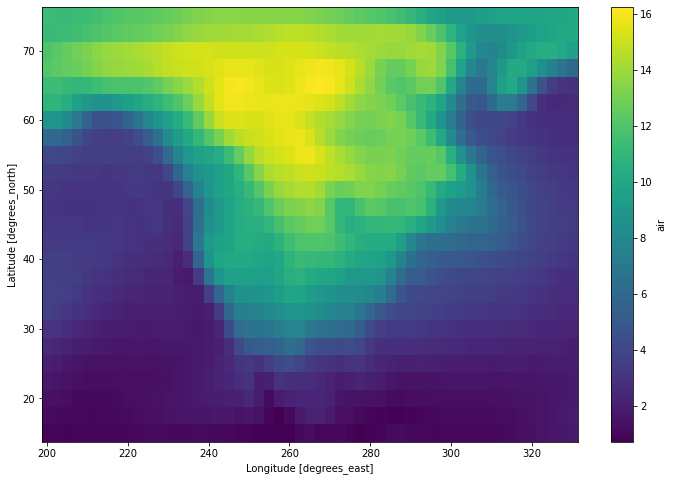

In [23]:
# plotting data 
da.resample(time='1w').mean('time').std('time').load().plot(figsize=(12, 8))

<div class="alert alert-info">
5. Finally, client and cluster must be closed. 
</div>


In [24]:
client.close()

In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
